In [36]:
import numpy as np
import pandas as pd
import re
import glob
import math
from lxml import etree
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import log_loss, auc, roc_curve
import matplotlib.pyplot as plt
from sklearn import preprocessing
import torch

def load_xml_files(directory):
    """Load and parse XML files into a DataFrame."""
    xml_list = glob.glob(f"{directory}/*.xml")
    parser = etree.XMLParser(recover=True)
    dfs = []

    for ii in xml_list:
        with open(ii, 'rb') as file:
            xml_data = file.read()
            dfs.append(xml2df(xml_data, parser))
    
    data = pd.concat(dfs)
    return data.drop_duplicates().sort_values("startDateTime")

def xml2df(xml_data, parser):
    """Convert XML data to pandas DataFrame."""
    root = etree.fromstring(xml_data, parser=parser)
    all_records = []
    for i, child in enumerate(root):
        record = {}
        for subchild in child:
            record[subchild.tag] = subchild.text
        all_records.append(record)
    return pd.DataFrame(all_records)

def preprocess_data(data):
    """Preprocess data by creating IP dyads and calculating bytes."""
    data['totalBytes'] = data['totalSourceBytes'].astype(float) + data['totalDestinationBytes'].astype(float)
    data['seqId'] = data['lowIP'] + '_' + data['highIP']  + '_' + data['startDateTime'].str[:13]
    data['protoBytes'] = data[['protocolName','totalBytes']].apply(
        lambda x: str(x[0])[0] + str(math.floor(np.log2(x[1] + 1.0))), axis=1)
    return data

def create_sequences(data, seq_len=10):
    """Generate sequences for modeling."""
    key = data.groupby('seqId')[['Tag','protoBytes']].agg({
        "Tag":lambda x: "%s" % ','.join([a for a in x]),
        "protoBytes":lambda x: "%s" % ','.join([str(a) for a in x])
    })

    attacks = [a.split(",") for a in key['Tag'].tolist()]
    sequences = [a.split(",") for a in key['protoBytes'].tolist()]

    # Normalization of tokens
    unique_tokens = list(set([a for b in sequences for a in b]))
    le = LabelEncoder()
    le.fit(unique_tokens)
    encoded_tokens = le.transform(unique_tokens)

    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_tokens = scaler.fit_transform(encoded_tokens.reshape(-1, 1)).flatten()
    token_to_normalized = dict(zip(le.classes_, normalized_tokens))
    sequences = [[token_to_normalized[token] for token in seq] for seq in sequences]

    # Convert text tags into integers
    for i in range(len(attacks)):
        attacks[i] = [1 if tag == 'Attack' else 0 for tag in attacks[i]]

    sequence_attack = zip(attacks, sequences)
    return create_model_sequences(sequence_attack, seq_len)

def create_model_sequences(sequence_attack, seq_len):
    """Prepare sequences for the model."""
    seq_x, seq_y, seq_index, seq_attack = [], [], [], []
    for si, (sa, ss) in enumerate(sequence_attack):
        prepend = [0.] * seq_len
        seq = prepend + ss
        seqa = prepend + sa
        for ii in range(seq_len, len(seq)):
            subseq = seq[(ii-seq_len+1):(ii+1)]
            subseqa = seqa[(ii-seq_len+1):(ii+1)]
            is_anomaly = int(any(subseqa))
            seq_x.append(subseq)
            seq_y.append(is_anomaly)
            seq_index.append(si)
            seq_attack.append(seqa[ii])

    frame = pd.DataFrame(seq_x)
    frame = pd.concat([frame, pd.DataFrame(seq_y)], axis=1)
    return frame, seq_x, seq_y, seq_index, seq_attack

# Load and process data
print("Loading data...")
data_directory = r"D:\AML\ISCX dataset\transformer"
data = load_xml_files(data_directory)
print("De-dup Flows:", len(data))
data = preprocess_data(data)
frame, seq_x, seq_y, seq_index, seq_attack = create_sequences(data)

print("Ready to Go!")

Loading data...
De-dup Flows: 925212


C:\Users\Yaphe\AppData\Local\Temp\ipykernel_4948\1803068807.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['lowIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] <= x[1] else x[1], axis=1)
C:\Users\Yaphe\AppData\Local\Temp\ipykernel_4948\1803068807.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['highIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] > x[1] else x[1], axis=1)
C:\Users\Yaphe\AppData\Local\Temp\ipykernel_4948\1803068807.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

Ready to Go!


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=1, padding='same')
        self.conv2 = nn.Conv1d(64, 64, kernel_size=5, stride=1, padding='same')
        self.maxpool = nn.MaxPool1d(2, stride=2)
        self.lstm = nn.LSTM(2*64, 64)#self.lstm = nn.LSTM(15*64, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        #x = F.tanh(self.conv1(x))
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        #x = F.tanh(self.conv2(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), 1, -1)
        x, (h_n, c_n) = self.lstm(x)
        x = x[:, -1, :]
        #x = F.tanh(self.fc1(x))
        x = F.relu(self.fc1(x))
        #x = F.log_softmax(self.fc2(x), dim=1)
        x = self.fc2(x)
        return x

In [39]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming 'frame' is a pandas DataFrame with your data

# Split the data
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# X = torch.tensor(frame1.iloc[:, 0:60].values).float().unsqueeze(1).to(device)
# y = torch.tensor(frame1.iloc[:, 60].values).long().to(device)
X = torch.tensor(frame.iloc[:, 0:10].values).float().unsqueeze(1).to(device)
y = torch.tensor(frame.iloc[:, 10].values).long().to(device)

# Create datasets
dataset = TensorDataset(X, y)

# Split into train and test
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

Using device: cuda:0


In [47]:
model = Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Epoch 1/150, Loss: 0.08244037913386765, Accuracy: 0.9767529952418577
Epoch 2/150, Loss: 0.06030043527969847, Accuracy: 0.9823112956371146
Epoch 3/150, Loss: 0.057918727418532955, Accuracy: 0.9826849369414624
Epoch 4/150, Loss: 0.05629136194382967, Accuracy: 0.9827698554197233
Epoch 5/150, Loss: 0.05463910596702881, Accuracy: 0.9828331582853359
Epoch 6/150, Loss: 0.052530546290542296, Accuracy: 0.983069279682433
Epoch 7/150, Loss: 0.050711895069733205, Accuracy: 0.9833242478566183
Epoch 8/150, Loss: 0.04921010652696898, Accuracy: 0.9836314983506895
Epoch 9/150, Loss: 0.048178710834870464, Accuracy: 0.9839774545227624
Epoch 10/150, Loss: 0.047321952816113656, Accuracy: 0.9842321035878436
Epoch 11/150, Loss: 0.04672011478616315, Accuracy: 0.9843216539831006
Epoch 12/150, Loss: 0.04613592289020068, Accuracy: 0.9844978795683531
Epoch 13/150, Loss: 0.04560465785001106, Accuracy: 0.9846862441928591
Epoch 14/150, Loss: 0.04521867925441077, Accuracy: 0.9847340009654502
Epoch 15/150, Loss: 0.044

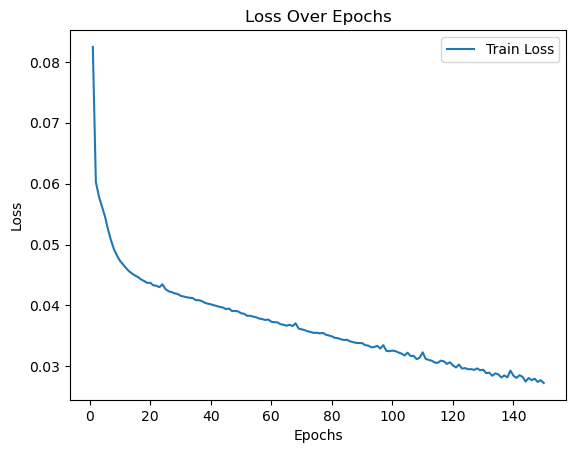

In [48]:
import matplotlib.pyplot as plt
import torch

def accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum().item()
    return correct / y_true.shape[0]

# To store loss values for each epoch
epoch_losses = []

epochs = 150
for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy(labels, outputs)

    # Average loss and accuracy for each epoch
    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)
    epoch_losses.append(epoch_loss)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

# Plotting the loss over epochs
plt.figure()
plt.plot(range(1, epochs+1), epoch_losses, label='Train Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Switch to evaluation mode
model.eval().to(device)
y_true = []
y_pred = []

data_loader = DataLoader(dataset, batch_size=512, shuffle=False)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

key_ll = zip(seq_index, y_pred, y_true)
dictionary = {}

for (key, p, t) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [p], current_value[1] + [t])

agg_true = []
agg_pred = []
for key, val in dictionary.items():
    true = int(np.sum(val[0]) > 0.)
    pred = int(np.sum(val[1]) > 0.)
    # if true != pred:
        # print(key, val[0], val[1])
        # print(true, pred)
    agg_true.append(true)
    agg_pred.append(pred)

# model_state_path = "lstm_model_state.pth"
# torch.save(model.state_dict(), model_state_path)

# Calculate metrics
Confusion_Matrix = confusion_matrix(agg_true, agg_pred)
Accuracy = accuracy_score(agg_true, agg_pred)
Precision = precision_score(agg_true, agg_pred, average='binary')
Recall = recall_score(agg_true, agg_pred, average='binary')
F1_Score = f1_score(agg_true, agg_pred, average='binary')

print("Confusion Matrix")
print(Confusion_Matrix)
print("Accuracy: ", Accuracy)
print("Precision: ", Precision)
print("Recall: ", Recall)
print("F1Score: ", F1_Score)

Confusion Matrix
[[20663   436]
 [  849  4409]]
Accuracy:  0.9512463482186896
Precision:  0.9100103199174406
Recall:  0.8385317611259033
F1Score:  0.8728100564188854


Epoch 1/100, Loss: 0.1741867203780785, Accuracy: 0.953566843622872
Epoch 2/100, Loss: 0.16298432743596467, Accuracy: 0.9535655671864556
Epoch 3/100, Loss: 0.15953442798301637, Accuracy: 0.9535660990349626
Epoch 4/100, Loss: 0.15541587257573727, Accuracy: 0.9539688630742159
Epoch 5/100, Loss: 0.15279235316241682, Accuracy: 0.9551797628613219
Epoch 6/100, Loss: 0.1501890990220511, Accuracy: 0.9560065874433726
Epoch 7/100, Loss: 0.1477436716730887, Accuracy: 0.9564886259200657
Epoch 8/100, Loss: 0.14598303685193006, Accuracy: 0.9568288316816159
Epoch 9/100, Loss: 0.1440473353733187, Accuracy: 0.9575021099880762
Epoch 10/100, Loss: 0.14189353526934334, Accuracy: 0.9576032675740798
Epoch 11/100, Loss: 0.14025256448819232, Accuracy: 0.9578133541809353
Epoch 12/100, Loss: 0.13871648676192808, Accuracy: 0.9578889024555026
Epoch 13/100, Loss: 0.13743046983899807, Accuracy: 0.9578088286336406
Epoch 14/100, Loss: 0.13576732625956592, Accuracy: 0.9580526698923977
Epoch 15/100, Loss: 0.135896912782

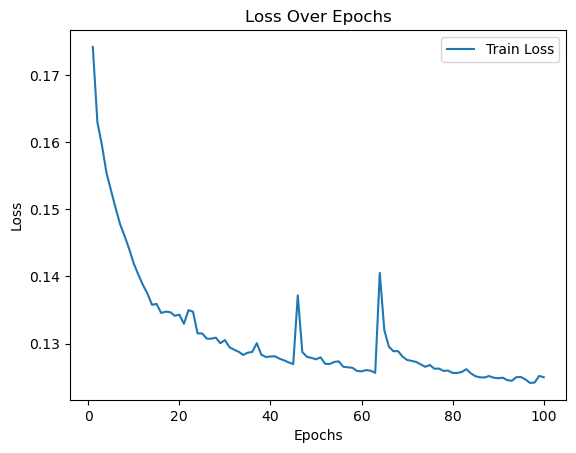

In [24]:
import matplotlib.pyplot as plt
import torch

def accuracy(y_true, y_pred):
    _, predicted = torch.max(y_pred, 1)
    correct = (predicted == y_true).float().sum().item()
    return correct / y_true.shape[0]

# To store loss values for each epoch
epoch_losses = []

epochs = 100
for epoch in range(epochs):
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_accuracy += accuracy(labels, outputs)

    # Average loss and accuracy for each epoch
    epoch_loss /= len(train_loader)
    epoch_accuracy /= len(train_loader)
    epoch_losses.append(epoch_loss)

    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}')

# Plotting the loss over epochs
plt.figure()
plt.plot(range(1, epochs+1), epoch_losses, label='Train Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Switch to evaluation mode
model.eval().to(device)
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

model_state_path = "model_state.pth"
torch.save(model.state_dict(), model_state_path)

# Calculate metrics
Confusion_Matrix = confusion_matrix(y_true, y_pred)
Accuracy = accuracy_score(y_true, y_pred)
Precision = precision_score(y_true, y_pred, average='binary')
Recall = recall_score(y_true, y_pred, average='binary')
F1_Score = f1_score(y_true, y_pred, average='binary')

print("Confusion Matrix")
print(Confusion_Matrix)
print("Accuracy: ", Accuracy)
print("Precision: ", Precision)
print("Recall: ", Recall)
print("F1Score: ", F1_Score)

Confusion Matrix
[[264444    128]
 [ 11230   1762]]
Accuracy:  0.959079707743079
Precision:  0.9322751322751323
Recall:  0.13562192118226601
F1Score:  0.23679612955247947
